In [21]:
import pandas as pd
import re
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Fungsi untuk menampilkan loading
def loading(message):
    print(f"\n{message}...")

# 1. Membaca Data Log
def read_log(file_path, num_lines, skip_lines=0):
    loading(f"Membaca data log dari {file_path}")
    with open(file_path, 'r', encoding='utf-8') as file:
        # Membaca semua baris
        log_lines = file.readlines()
        
        # Mengambil baris setelah skip_lines
        log_lines = log_lines[skip_lines:skip_lines + num_lines]
    
    log_data = pd.DataFrame([re.match(r'(?P<ip>[\d\.]+) - - \[(?P<time>[^\]]+)\] "(?P<request>[^"]+)" (?P<status>\d+) (?P<size>\d+) "(?P<referrer>[^"]*)" "(?P<user_agent>[^"]*)"', line).groups() for line in log_lines if re.match(r'(?P<ip>[\d\.]+) - - \[(?P<time>[^\]]+)\] "(?P<request>[^"]+)" (?P<status>\d+) (?P<size>\d+) "(?P<referrer>[^"]*)" "(?P<user_agent>[^"]*)"', line)])
    log_data.columns = ['ip', 'time', 'request', 'status', 'size', 'referrer', 'user_agent']
    return log_data

# Membaca dataset
new_log_data = read_log('new.log', 10000)
old_log_data = read_log('old.log', 10000, skip_lines=100000)


Membaca data log dari new.log...

Membaca data log dari old.log...


In [22]:
# 2. Pre-processing Data
loading("Pre-processing data")

# Mengonversi kolom 'size' menjadi numerik
new_log_data['size'] = pd.to_numeric(new_log_data['size'], errors='coerce')
old_log_data['size'] = pd.to_numeric(old_log_data['size'], errors='coerce')

# Mengonversi kolom 'time' menjadi datetime
new_log_data['time'] = pd.to_datetime(new_log_data['time'], format='%d/%b/%Y:%H:%M:%S %z')
old_log_data['time'] = pd.to_datetime(old_log_data['time'], format='%d/%b/%Y:%H:%M:%S %z')

# Ekstrak fitur dari kolom 'time'
new_log_data['hour'] = new_log_data['time'].dt.hour
new_log_data['day'] = new_log_data['time'].dt.day
new_log_data['month'] = new_log_data['time'].dt.month

old_log_data['hour'] = old_log_data['time'].dt.hour
old_log_data['day'] = old_log_data['time'].dt.day
old_log_data['month'] = old_log_data['time'].dt.month

# Ekstrak metode dari kolom 'request'
new_log_data['method'] = new_log_data['request'].apply(lambda x: x.split(' ')[0])
old_log_data['method'] = old_log_data['request'].apply(lambda x: x.split(' ')[0])

# Ekstrak uri dari kolom 'request'
new_log_data['uri'] = new_log_data['request'].apply(lambda x: x.split(' ')[1])
old_log_data['uri'] = old_log_data['request'].apply(lambda x: x.split(' ')[1])

# Gabungkan kedua dataset untuk one-hot encoding
combined_data = pd.concat([new_log_data, old_log_data], ignore_index=True)

# One-hot encoding untuk kolom 'status', 'method', dan 'uri'
encoder_status = OneHotEncoder(sparse_output=False)
status_encoded = encoder_status.fit_transform(combined_data[['status']])

encoder_method = OneHotEncoder(sparse_output=False)
method_encoded = encoder_method.fit_transform(combined_data[['method']])

encoder_uri = OneHotEncoder(sparse_output=False)
uri_encoded = encoder_uri.fit_transform(combined_data[['uri']])

# Menggabungkan fitur yang telah di-encode
combined_data_encoded = pd.concat([combined_data.reset_index(drop=True), 
                                    pd.DataFrame(status_encoded, columns=encoder_status.get_feature_names_out(['status'])),
                                    pd.DataFrame(method_encoded, columns=encoder_method.get_feature_names_out(['method'])),
                                    pd.DataFrame(uri_encoded, columns=encoder_uri.get_feature_names_out(['uri']))], axis=1)

# Pisahkan kembali dataset
new_log_data_encoded = combined_data_encoded.iloc[:len(new_log_data)]
old_log_data_encoded = combined_data_encoded.iloc[len(new_log_data):]

# Menggunakan fitur yang relevan untuk pelatihan
features = ['size', 'hour', 'day', 'month'] + list(encoder_status.get_feature_names_out(['status'])) + list(encoder_method.get_feature_names_out(['method'])) + list(encoder_uri.get_feature_names_out(['uri']))

new_data = new_log_data_encoded[features].values
old_data = old_log_data_encoded[features].values

# Normalisasi data
scaler = MinMaxScaler()
new_data_scaled = scaler.fit_transform(new_data)
old_data_scaled = scaler.transform(old_data)

# Membentuk data menjadi urutan untuk LSTM
def create_sequences(data, time_step=1):
    X = []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])
    return np.array(X)

time_step = 5  # Panjang urutan
X_train = create_sequences(new_data_scaled, time_step)
X_test = create_sequences(old_data_scaled, time_step)

# Reshape data untuk LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))


Pre-processing data...


In [23]:
# 3. Membangun Model Autoencoder LSTM
loading("Membangun model Autoencoder LSTM")

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(X_train.shape[2])))

model.compile(optimizer='adam', loss='mse')

# 4. Melatih Model
loading("Melatih model")
history = model.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.1)


Membangun model Autoencoder LSTM...


c:\Users\MSI-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Melatih model...
Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 6.1765e-04 - val_loss: 3.3117e-04
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 3.2620e-04 - val_loss: 2.6912e-04
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 2.6146e-04 - val_loss: 2.5566e-04
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 2.4804e-04 - val_loss: 2.3559e-04
Epoch 5/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 2.2597e-04 - val_loss: 2.2275e-04
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 2.0874e-04 - val_loss: 1.9878e-04
Epoch 7/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 1.8322e-04 - val_loss: 1.6859e-04
Epoch 8/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 1.6216e-04 - val_loss: 1.5917e-04
Epoch 9/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 1.5214e-04 - val_loss: 1.5586e-04
Epoch 10/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 1.4649e-04 - val_loss: 1.5493e-04
Epoch 11/50
282/282 ━━━━━━━━━━

In [24]:
# 5. Menguji Model
loading("Mengujii model")
X_test_pred = model.predict(X_test)


Mengujii model...
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step


In [25]:
# 6. Evaluasi
# Menghitung error rekonstruksi
# reconstruction_error = np.mean(np.abs(X_test_pred - X_test), axis=1) # Digunakan saat masih hanya menggunakan "size" dalam proses training
reconstruction_error = np.mean(np.abs(X_test_pred - X_test), axis=(1, 2))  # Rata-rata di sepanjang dimensi waktu dan fitur

# Menentukan ambang batas untuk mendeteksi anomali
threshold = np.percentile(reconstruction_error, 95)  # Ambang batas diambil dari persentil 95

# Menandai anomali
anomalies = reconstruction_error > threshold

# Menghitung MSE, MAE, dan RMSE
mse = mean_squared_error(X_test.flatten(), X_test_pred.flatten())
mae = mean_absolute_error(X_test.flatten(), X_test_pred.flatten())
rmse = np.sqrt(mse)

# Menghitung jumlah anomali
num_anomalies = np.sum(anomalies)

# Menampilkan hasil
loading("Menampilkan hasil deteksi anomali")
anomaly_indices = np.where(anomalies)[0]
for index in anomaly_indices:
    print(f"Anomali terdeteksi pada indeks {index + time_step}: Error rekonstruksi = {reconstruction_error[index]}")


Menampilkan hasil deteksi anomali...
Anomali terdeteksi pada indeks 227: Error rekonstruksi = 0.005898838010388523
Anomali terdeteksi pada indeks 239: Error rekonstruksi = 0.006172276551914946
Anomali terdeteksi pada indeks 240: Error rekonstruksi = 0.007300637449434806
Anomali terdeteksi pada indeks 241: Error rekonstruksi = 0.006663813407436475
Anomali terdeteksi pada indeks 261: Error rekonstruksi = 0.005449125810836252
Anomali terdeteksi pada indeks 262: Error rekonstruksi = 0.006968956156565081
Anomali terdeteksi pada indeks 355: Error rekonstruksi = 0.006313888149993586
Anomali terdeteksi pada indeks 358: Error rekonstruksi = 0.005269176220814524
Anomali terdeteksi pada indeks 434: Error rekonstruksi = 0.005796773534056676
Anomali terdeteksi pada indeks 469: Error rekonstruksi = 0.00532179407259656
Anomali terdeteksi pada indeks 476: Error rekonstruksi = 0.005786695884166789
Anomali terdeteksi pada indeks 558: Error rekonstruksi = 0.005782237843661644
Anomali terdeteksi pada ind

In [26]:
# Menampilkan evaluasi
print(f"\nEvaluasi Hasil:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Jumlah Anomali yang Terdeteksi: {num_anomalies}")


Evaluasi Hasil:
Mean Squared Error (MSE): 0.005253541328376515
Mean Absolute Error (MAE): 0.004076604833195978
Root Mean Squared Error (RMSE): 0.07248131709879806
Jumlah Anomali yang Terdeteksi: 500


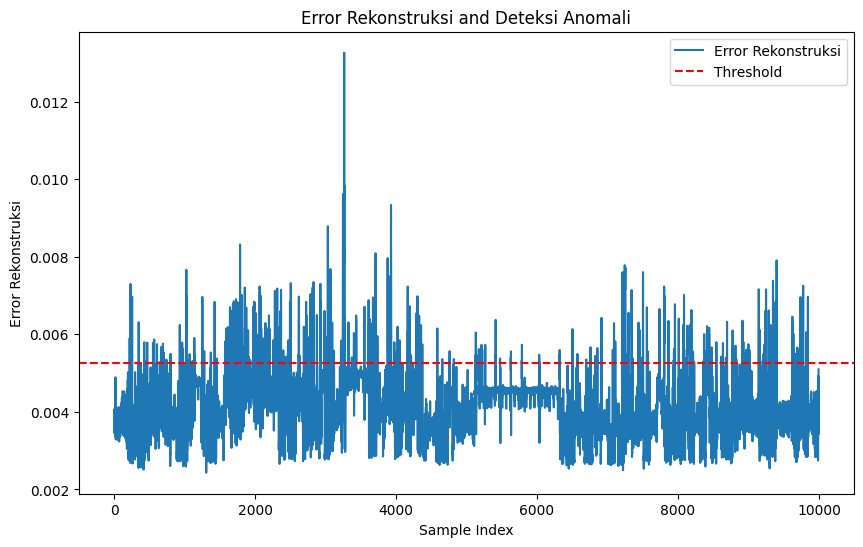

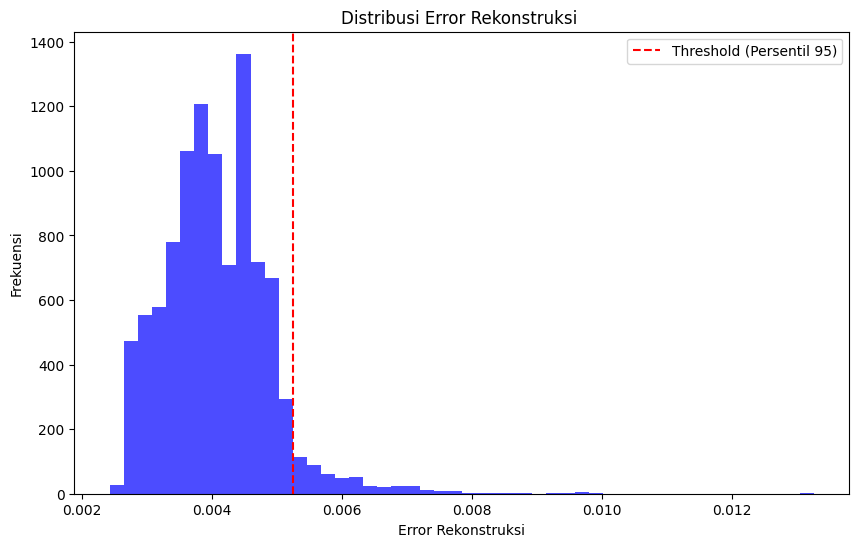

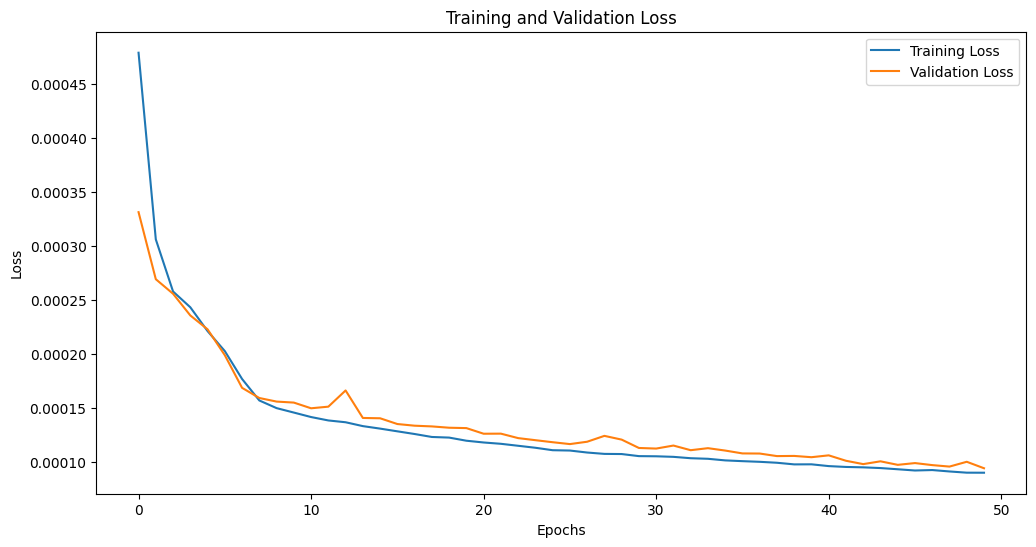

In [27]:
# Visualisasi Error Rekonstruksi
plt.figure(figsize=(10, 6))
plt.plot(reconstruction_error, label='Error Rekonstruksi')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Error Rekonstruksi and Deteksi Anomali')
plt.xlabel('Sample Index')
plt.ylabel('Error Rekonstruksi')
plt.legend()
plt.show()

# Visualisasi Distribusi Error Rekonstruksi
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_error, bins=50, alpha=0.7, color='blue')
plt.axvline(x=np.percentile(reconstruction_error, 95), color='red', linestyle='--', label='Threshold (Persentil 95)')
plt.title('Distribusi Error Rekonstruksi ')
plt.xlabel('Error Rekonstruksi')
plt.ylabel('Frekuensi')
plt.legend()
plt.show()

# Visualisasi loss pelatihan dan validasi
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
# 7. Identifikasi Anomali
from collections import defaultdict, Counter

# Definisikan threshold dan rentang waktu
X = 5  # Jumlah maksimum percobaan gagal yang diizinkan
Y = 60  # Rentang waktu dalam detik
threshold_dos = 60  # Threshold untuk deteksi DoS

# Fungsi untuk mengidentifikasi pola serangan
def detect_attack_patterns(log_entry, failed_attempts, request_times):
    ip = log_entry['ip']
    request = log_entry['request']
    status = log_entry['status']
    
    # Mengonversi waktu dengan format yang sesuai
    log_time = pd.to_datetime(log_entry['time'], format='%d/%b/%Y:%H:%M:%S %z')  # Format waktu yang sesuai
    
    # 1. Brute Force Detection Rule
    if status == '401':  # Misalnya, status 401 menunjukkan kegagalan otentikasi
        failed_attempts[ip] += 1
        if failed_attempts[ip] > X:  # X adalah threshold yang diinginkan
            return "Brute Force Attack Detected"
    
    # 2. SQL Injection Detection Rule
    if re.search(r'.*(UNION|SELECT|INSERT|DELETE|UPDATE|DROP|--|#|;|\').*', request , re.IGNORECASE):
        return "SQL Injection Attack Detected"
    
    # 3. XSS Detection Rule
    if re.search(r'.*(<script>|%3Cscript%3E|javascript:).*', request, re.IGNORECASE):
        return "XSS Attack Detected"
    
    # 4. DoS Detection Rule
    if ip in request_times:
        request_times[ip].append(log_time)
        # Hanya ambil permintaan dalam rentang waktu tertentu
        request_times[ip] = [t for t in request_times[ip] if (log_time - t).total_seconds() < Y]  # Y adalah rentang waktu
        if len(request_times[ip]) > threshold_dos:
            return "DoS Attack Detected"
    else:
        request_times[ip] = [log_time]
    
    # 5. Directory Traversal Detection Rule
    if re.search(r'\.\./', request):
        return "Directory Traversal Attack Detected"
    
    return None

# Fungsi untuk mengidentifikasi parameter URI berbahaya
def detect_malicious_uri(log_entry):
    request = log_entry['request']
    
    # Daftar pola yang mencurigakan
    suspicious_patterns = {
        # "Malicious URI Detected (Creativity)": r'/Slot|slot|Zeus|zeus|ZEUS|Jackpot|JACKPOT|999|888|777|666|555|JP|WD|I',
        "Malicious URI Detected (Creativity)": r'/Slot|slot|Zeus|zeus|ZEUS|Jackpot|JACKPOT|999|888|777|666|555|JP|WD|I|bagas31|igg|fitgirl|skidrow|hienzo|oceanofgames|ovagames|newgamesbox|fullypcgames|apunkagames|cracked|pcgames|freegames|freepcgames|tasikgame|gigapurbalingga',
        "Malicious URI Detected (SQL Syntax)": r'/JOIN|SELECT|UNION',
        "Malicious URI Detected (XSS)": r'<script>|%3Cscript%3E|javascript:',
        "Malicious URI Detected (Command Injection)": r'(?i)(cmd|exec|system|shell|bash|sh|powershell)',
        "Malicious URI Detected (Directory Traversal)": r'\.\./|\.\.\\',
        "Malicious URI Detected (File Inclusion)": r'(?i)(include|require|file_get_contents|fopen|readfile)',
        "Malicious URI Detected (Remote File Inclusion)": r'(?i)(http|https|ftp)://'
    }
    
    # Cek setiap pola dalam daftar
    for label, pattern in suspicious_patterns.items():
        if re.search(pattern, request):
            return label  # Kembalikan label jika pola terdeteksi
    
    # 2. Based On Curiosity
    suspicious_patterns = [
        '%20',  # URL encoding for space
        '%',  # Semua URL encoding UTF-8 ada persennya
        'http://example.com',  # Contoh URL yang mencurigakan
        'http://malicious.com',  # Contoh URL yang mencurigakan
        'eval(',  # Fungsi eval yang sering disalahgunakan
        'base64_decode(',  # Fungsi base64_decode yang sering disalahgunakan
        '<script>',  # Tag script yang mencurigakan
        'javascript:',  # Protokol javascript
    ]
    
    for pattern in suspicious_patterns:
        if pattern in request:
            return "Malicious URI Detected (Curiosity)"
    
    return None

In [29]:
# Mengidentifikasi dan memberi label pada anomali
loading("Mengidentifikasi dan memberi label pada anomali")

failed_attempts = defaultdict(int)
request_times = {}

anomaly_labels = []

# Pastikan untuk menggunakan ukuran yang benar
for i in range(len(old_log_data)):
    if i < len(anomalies) and anomalies[i]:  # Cek apakah indeks valid
        log_entry = old_log_data.iloc[i]
        
        # Identifikasi pola serangan
        attack_label = detect_attack_patterns(log_entry, failed_attempts, request_times)
        if attack_label:
            anomaly_labels.append((log_entry, attack_label))
            continue
        
        # Identifikasi parameter URI berbahaya
        uri_label = detect_malicious_uri(log_entry)
        if uri_label:
            anomaly_labels.append((log_entry, uri_label))

# Menampilkan hasil identifikasi
loading("Menampilkan hasil identifikasi")
for entry, label in anomaly_labels:
    print(f"Anomali teridentifikasi: {label} pada {entry['time']} dari IP {entry['ip']}")


Mengidentifikasi dan memberi label pada anomali...

Menampilkan hasil identifikasi...
Anomali teridentifikasi: Malicious URI Detected (Creativity) pada 2022-12-24 15:08:57+07:00 dari IP 66.249.79.63
Anomali teridentifikasi: Malicious URI Detected (Creativity) pada 2022-12-24 16:00:12+07:00 dari IP 10.220.34.199
Anomali teridentifikasi: Malicious URI Detected (File Inclusion) pada 2022-12-24 16:55:29+07:00 dari IP 85.215.100.221
Anomali teridentifikasi: Malicious URI Detected (Command Injection) pada 2022-12-24 17:02:49+07:00 dari IP 20.166.10.103
Anomali teridentifikasi: Malicious URI Detected (Creativity) pada 2022-12-24 17:58:57+07:00 dari IP 10.220.34.199
Anomali teridentifikasi: Malicious URI Detected (Command Injection) pada 2022-12-24 18:11:20+07:00 dari IP 36.71.73.217
Anomali teridentifikasi: Malicious URI Detected (Command Injection) pada 2022-12-24 18:17:57+07:00 dari IP 20.203.172.170
Anomali teridentifikasi: Malicious URI Detected (File Inclusion) pada 2022-12-24 18:21:21+

In [30]:
label_counts = Counter(label for _, label in anomaly_labels)

print("\nJumlah anomali teridentifikasi berdasarkan label:")
for label, count in label_counts.items():
    print(f" {label}: {count}")
    
print(f"\nTeridentifikasi {len(anomaly_labels)} dari {num_anomalies} anomali yang terdeteksi.")


Jumlah anomali teridentifikasi berdasarkan label:
 Malicious URI Detected (Creativity): 34
 Malicious URI Detected (File Inclusion): 9
 Malicious URI Detected (Command Injection): 14
 SQL Injection Attack Detected: 8
 Malicious URI Detected (Curiosity): 31
 Malicious URI Detected (Remote File Inclusion): 4

Teridentifikasi 100 dari 500 anomali yang terdeteksi.
